In [1]:
import pandas as pd
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Load and Parse File
with open("noisy_data.txt", "r", encoding='utf-8') as f:
    lines = f.readlines()

customer_data = []
loan_data = []

for line in lines:
    line = line.strip()
    if line.startswith("name"):
        customer_data.append(line)
    elif line.startswith('{"loan_id"'):
        try:
            json_str = line.split("},")[0] + "}"
            loan_data.append(json.loads(json_str))
        except:
            continue

In [4]:
# Step 2: Clean Customer Data
customer_records = []
for row in customer_data:
    try:
        parts = row.split(",")
        record = {
            "name": parts[1],
            "gender": parts[3],
            "address": parts[5].replace('"', ''),
            "pan": parts[7],
            "dob": parts[9],
            "dpd": int(parts[-1])
        }
        customer_records.append(record)
    except:
        continue

In [5]:
# Step 3: Create DataFrames
df_customers = pd.DataFrame(customer_records)
df_loans = pd.DataFrame(loan_data)

In [6]:
# Step 4: Add Synthetic Key
df_customers['customer_id'] = range(1, len(df_customers)+1)
df_loans['customer_id'] = range(1, len(df_loans)+1)

In [7]:
# Step 5: SQL Join
conn = sqlite3.connect(":memory:")
df_customers.to_sql("customers", conn, index=False, if_exists="replace")
df_loans.to_sql("loans", conn, index=False, if_exists="replace")

query = """
SELECT 
    c.name, c.gender, c.address, c.pan, c.dob, c.dpd AS customer_dpd,
    l.loan_id, l.amount, l.tenure, l.status, l.start_date, l.dpd AS loan_dpd
FROM customers c
JOIN loans l ON c.customer_id = l.customer_id
"""

joined_df = pd.read_sql_query(query, conn)


In [8]:
# Step 6: Export
joined_df.to_csv("joined_data.csv", index=False)


In [9]:
# Step 7: Visualization Setup
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Loan Status Count')

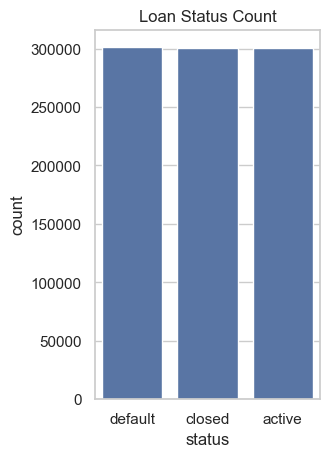

In [10]:
# 1. Loan Status Count
plt.subplot(1, 2, 1)
sns.countplot(data=joined_df, x='status')
plt.title('Loan Status Count')

Text(0.5, 1.0, 'Loan DPD Distribution')

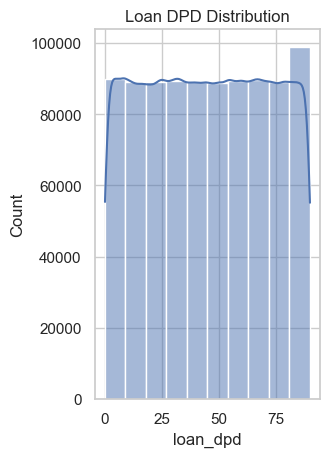

In [11]:
# 2. DPD Distribution (Loan)
plt.subplot(1, 2, 2)
sns.histplot(data=joined_df, x='loan_dpd', bins=10, kde=True)
plt.title('Loan DPD Distribution')

Text(0, 0.5, 'DPD (Loan)')

C:\Users\Rajan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Rajan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


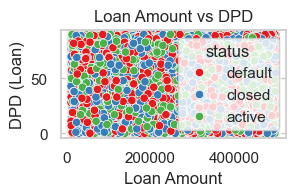

In [12]:
# 3. Loan Amount vs DPD
plt.subplot(3, 2, 3)
sns.scatterplot(data=joined_df, x='amount', y='loan_dpd', hue='status', palette='Set1')
plt.title('Loan Amount vs DPD')
plt.xlabel('Loan Amount')
plt.ylabel('DPD (Loan)')

C:\Users\Rajan\AppData\Local\Temp\ipykernel_10748\4245033671.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=joined_df, x='tenure', y='amount', palette='coolwarm')


Text(0, 0.5, 'Loan Amount')

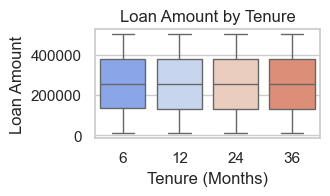

In [13]:
# 4. Tenure vs Amount
plt.subplot(3, 2, 4)
sns.boxplot(data=joined_df, x='tenure', y='amount', palette='coolwarm')
plt.title('Loan Amount by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Loan Amount')

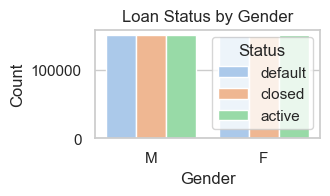

In [14]:
# 5. Gender vs Status
plt.subplot(3, 2, 5)
sns.countplot(data=joined_df, x='gender', hue='status', palette='pastel')
plt.title('Loan Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Status')

In [15]:
plt.tight_layout()
plt.savefig("visualizations.png")
plt.show()


<Figure size 640x480 with 0 Axes>

In [16]:
# Group by gender and status, then count
loan_status_by_gender = joined_df.groupby(['gender', 'status']).size().reset_index(name='count')
print(loan_status_by_gender)


  gender   status   count
0      F   active  150326
1      F   closed  149991
2      F  default  149960
3      M   active  150178
4      M   closed  150306
5      M  default  151142


In [17]:
total_loan_amount = joined_df['amount'].sum()
print("Total Loan Amount:", total_loan_amount)


Total Loan Amount: 229901089635
